In [ ]:
!pip install tensornetwork

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 364 kB 8.0 MB/s 
     |████████████████████████████████| 47 kB 5.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import matplotlib.pyplot as plt
import logging
import numpy as np
import math
import tensornetwork as tn
from albumentations.augmentations.crops.transforms import CenterCrop
import logging
from pgm import create_node
from pgm import create_node_from_pgm
from pgm import crop_pgm_image
from ipywidgets import interact

In [ ]:
file_l = ['nightshot_iso_100.pgm']

def getInitialMatrix():
  for file_name in file_l:
    with open(file_name, 'rb') as pgmf:
      im = plt.imread(pgmf)
      img = crop_pgm_image(im)
      A = np.array(img)
      R = A>0.5
      R[R == True] = 1 
      R[R == False] = 0
      R = R.astype(np.float64, copy=False)

      return A, R

def ALS(A, R, n_factors, n_iterations, lambda_):
    '''
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    '''
    #print("Initiating ")
    # lambda_ = 0.1; n_factors = 30; n, m = A.shape; n_iterations = 10
    n, m = A.shape;
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    # MSE_List = []

    #print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(np.dot(Items, np.dot(np.diag(Ri), Items.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(Items, np.dot(np.diag(Ri), A[i].T))).T
        #print("Error after solving for User Matrix:", get_error(A, Users, Items, R))

        for j, Rj in enumerate(R.T):
            Items[:,j] = np.linalg.solve(np.dot(Users.T, np.dot(np.diag(Rj), Users)) + lambda_ * np.eye(n_factors),
                                     np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])))
        #print("Error after solving for Item Matrix:", get_error(A, Users, Items, R))

        # MSE_List.append(get_error(A, Users, Items, R))
        #print('%sth iteration is complete...' % iter)

    #print(MSE_List)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d users and %d movies' % A.shape);
    # plt.show()


    return Users, Items

def loss(original, reconst):
    n, m = original.shape
    return np.sum((reconst - original)**2) / (n * m)

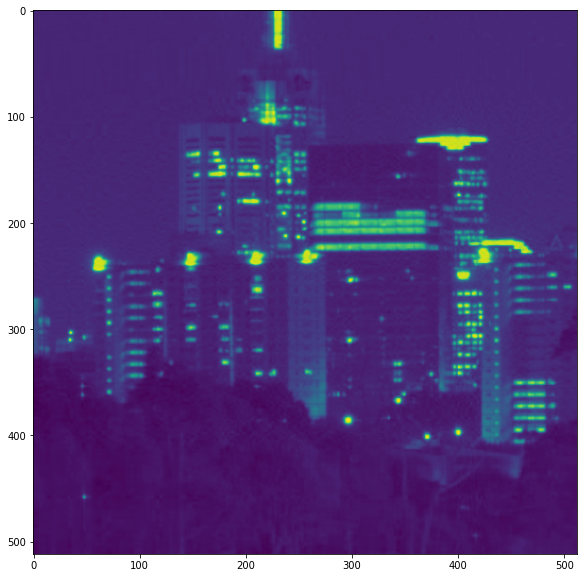

In [ ]:
A, R = getInitialMatrix()
Users, Items = ALS(A, R, n_factors = 75, n_iterations = 10, lambda_ = .1)
matrix = Users @ Items
fig = plt.figure(figsize=(32, 10))
ax = fig.add_subplot(121)
plt.imshow(matrix)

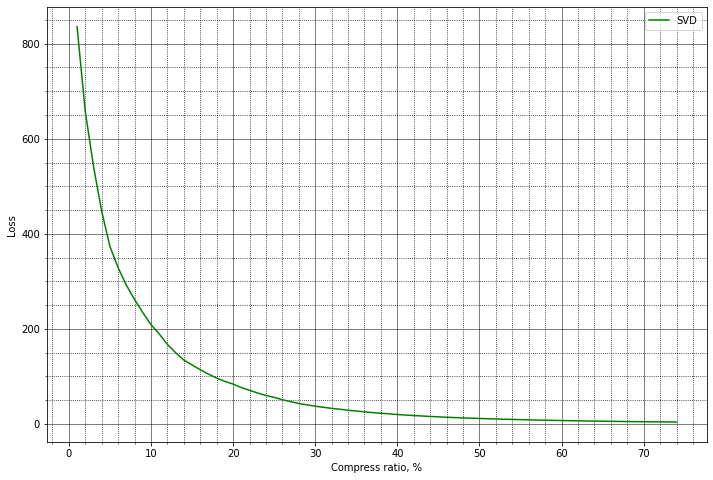

In [ ]:
file_l = ['nightshot_iso_100.pgm']
for file_name in file_l:
    with open(file_name, 'rb') as pgmf:
      im = plt.imread(pgmf)
      img = crop_pgm_image(im)
A, R = getInitialMatrix()
loss_list = []
for i in range(1,75):
  Users, Items = ALS(A, R, n_factors = i, n_iterations = 10, lambda_ = .1)
  matrix = Users @ Items
  loss_list.append(loss(img, matrix))


compress_ratio = [x for x in range(1,75)]
fig = plt.figure(figsize=(26, 8))
ax = fig.add_subplot(121)
ax.minorticks_on()
ax.grid(which='major',
            color = 'k', 
            linewidth = 0.5)
ax.grid(which='minor', 
            color = 'k', 
            linestyle = ':')
plt.plot(compress_ratio, loss_list, c='green', label='SVD')
plt.ylabel('Loss')
plt.xlabel('Compress ratio, %')
plt.legend(loc='best')
#plt.title(f'{img_name}', loc='center')
plt.show()
  